# **SKIN CANCER CLASSIFICATION**
---
Pretrained model implementation : **VGG16**

## Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import PIL
import os
import pathlib
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
import gc

## **Step 1** -> Importing the dataset from kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukethk","key":"b8e4d1b1ba7da20b149639cc2cf652e7"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.17G/5.20G [00:25<00:00, 223MB/s]
100% 5.20G/5.20G [00:25<00:00, 220MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip

In [ ]:
!mkdir images

In [ ]:
len(os.listdir('/content/HAM10000_images_part_1')), len(os.listdir('/content/HAM10000_images_part_2'))

(5000, 5015)

In [ ]:
dest_path = '/content/images'
path1 = '/content/HAM10000_images_part_1'
path2 = '/content/HAM10000_images_part_2'

In [ ]:
import shutil

images1 = [f for f in os.listdir(path1) if '.jpg' in f.lower()]
images2 = [f for f in os.listdir(path2) if '.jpg' in f.lower()]

for image in images1:
  old_path = path1 + '/' +image
  new_path = dest_path + '/' + image
  shutil.move(old_path, new_path)

for image in images2:
  old_path = path2 + '/' +image
  new_path = dest_path + '/' + image
  shutil.move(old_path, new_path)

del images1
del images2

gc.collect()

371

In [ ]:
len(os.listdir(path1)), len(os.listdir(path2))

(0, 0)

In [ ]:
len(os.listdir(dest_path))

10015

Util function to monitor the RAM usage :

In [ ]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
  memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
  memory_usage_by_variable=memory_usage_by_variable.T
  memory_usage_by_variable=memory_usage_by_variable\
   .sort_values(by='Size',ascending=False).head(10)
  memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))

  return memory_usage_by_variable


In [ ]:
df = pd.read_csv('/content/HAM10000_metadata.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


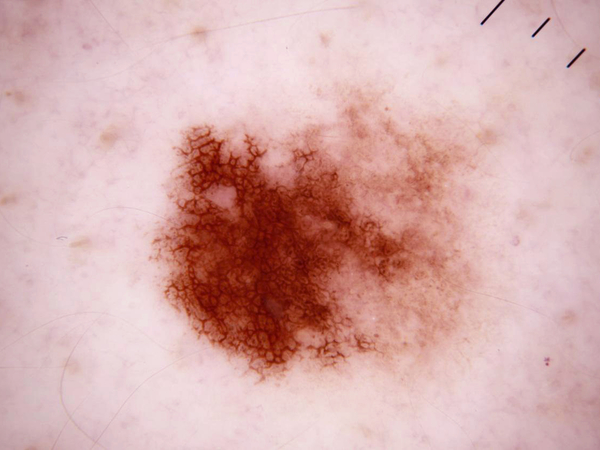

In [ ]:
PIL.Image.open(dest_path+'/'+df['image_id'][8765]+'.jpg')

In [ ]:
print(df['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [ ]:
print(df['dx_type'].unique())

['histo' 'consensus' 'confocal' 'follow_up']


## **Step 2** -> Data preprocessing :
---
Assumptions :

* Input : image ( numpy array )
* Ouput : categorical ( 0 - 6 )

In [ ]:
df.drop(columns = ['lesion_id', 'dx_type', 'age', 'sex', 'localization'], inplace=True)

In [ ]:
df

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


One hot encoding the type of disease :

In [ ]:
df1 = pd.get_dummies(data=df, columns=['dx'])

In [ ]:
dx_dict = {
    0 : 'akiec',
    1 : 'bcc',
    2 : 'bkl',
    3 : 'df',
    4 : 'mel',
    5 : 'nv',
    6 : 'vasc'
}

In [ ]:
df1

,image_id,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
0,ISIC_0027419,0,0,1,0,0,0,0
1,ISIC_0025030,0,0,1,0,0,0,0
2,ISIC_0026769,0,0,1,0,0,0,0
3,ISIC_0025661,0,0,1,0,0,0,0
4,ISIC_0031633,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
10010,ISIC_0033084,1,0,0,0,0,0,0
10011,ISIC_0033550,1,0,0,0,0,0,0
10012,ISIC_0033536,1,0,0,0,0,0,0
10013,ISIC_0032854,1,0,0,0,0,0,0


Image resizing : (180,180,3)

In [ ]:
import cv2

In [ ]:
X = []

for img in df['image_id']:
  image = cv2.imread('/content/images/'+img+'.jpg')
  resized_image = cv2.resize(image, (180,180))
  X.append(resized_image)

In [ ]:
df2 = df1.drop(columns=['image_id'])
y = df2.to_numpy(copy=True)

In [ ]:
X = np.array(X)

In [ ]:
f'input shape : {X.shape}, output shape : {y.shape}'

'input shape : (10015, 180, 180, 3), output shape : (10015, 7)'

In [ ]:
def plot_sample(X,y,index):
  plt.figure(figsize = (15,2))
  plt.imshow(X[index])
  plt.xlabel(dx_dict[np.argmax(y[index])])

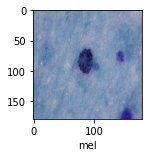

In [ ]:
plot_sample(X,y,10014)

Training and test data set split 

* Train : 80%
* Test : 20%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
memory_usage()

,Size
X,950.64MB
X_train,760.51MB
X_test,190.13MB
df,1.26MB
_16,1.26MB
___,1.26MB
_21,1.26MB
image,791.15KB
__,743.46KB
df1,743.46KB


In [ ]:
import gc

del X
del y
del df
del df1
gc.collect()

2097

In [ ]:
memory_usage()

,Size
X_train,760.51MB
X_test,190.13MB
_21,1.26MB
_16,1.26MB
image,791.15KB
_24,743.46KB
resized_image,95.05KB
df2,68.62KB
y_train,54.89KB
y_test,13.81KB


Scaling the images using the custom scaling function provided by keras

In [ ]:
X_train_scaled_vgg16 = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test_scaled_vgg16 = tf.keras.applications.vgg16.preprocess_input(X_test)

In [ ]:
memory_usage()

,Size
X_train,760.51MB
X_test,190.13MB
_16,1.26MB
_21,1.26MB
image,791.15KB
_24,743.46KB
resized_image,95.05KB
df2,68.62KB
y_train,54.89KB
y_test,13.81KB


In [ ]:
del X_train
del X_test

gc.collect()

88

In [ ]:
memory_usage()

,Size
_21,1.26MB
_16,1.26MB
image,791.15KB
_24,743.46KB
resized_image,95.05KB
df2,68.62KB
y_train,54.89KB
y_test,13.81KB
___,1.27KB
__,1.27KB


Data augmentation to improve accuracy

In [ ]:
img_height, img_width = 180,180

data_augmentation = keras.Sequential(
    [
     keras.layers.experimental.preprocessing.RandomFlip('horizontal',
                                                        input_shape=(img_height,
                                                                     img_width,3)),
     keras.layers.experimental.preprocessing.RandomRotation(0.1),
     keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

## **Step 3** -> Designing the model
---
The deep learning model has two stages :


1.   CNN (from the pretrained model)
2.   ANN

* The CNN part is extracted from the pretrained model by removing the top layers.


> > The output of the CNN layer will be the feature map of the image.

* The input for the ANN will be the flattened feature map.
* ANN classifies the image into 7 categories





# **VGG16** 

> * This is the entry level model of VGG range of pretrained models.
> * *VGG16* is also trained using the imagenet dataset

## Part 1.1 : Model definition

In [ ]:
vgg16_base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(180,180,3),
    pooling='avg',
    classifier_activation="softmax",
)

vgg16_base_model.trainable = False

vgg16_model = keras.Sequential([
  data_augmentation,
  vgg16_base_model,
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation = 'relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(7, activation = 'softmax')                          
])

vgg16_model.summary()

vgg16_model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                       

In [ ]:
gc.collect()

1026

In [ ]:
memory_usage()

## Part 1.2 : Training by freezing the CNN layers

In [ ]:
vgg16_model.fit(X_train_scaled_vgg16,y_train,batch_size=32,epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 29s 62ms/step - loss: 1.0066 - accuracy: 0.6787
Epoch 2/25
251/251 [==============================] - 15s 61ms/step - loss: 0.7553 - accuracy: 0.7327
Epoch 3/25
251/251 [==============================] - 15s 61ms/step - loss: 0.6919 - accuracy: 0.7455
Epoch 4/25
251/251 [==============================] - 15s 61ms/step - loss: 0.6555 - accuracy: 0.7597
Epoch 5/25
251/251 [==============================] - 15s 61ms/step - loss: 0.6262 - accuracy: 0.7688
Epoch 6/25
251/251 [==============================] - 15s 61ms/step - loss: 0.5824 - accuracy: 0.7832
Epoch 7/25
251/251 [==============================] - 15s 61ms/step - loss: 0.5846 - accuracy: 0.7818
Epoch 8/25
251/251 [==============================] - 15s 61ms/step - loss: 0.5486 - accuracy: 0.7961
Epoch 9/25
251/251 [==============================] - 15s 61ms/step - loss: 0.5437 - accuracy: 0.7976
Epoch 10/25
251/251 [==============================] - 15s 61ms/step - loss: 0.5309 - accurac

In [ ]:
memory_usage()

,Size
_21,1.26MB
_16,1.26MB
image,791.15KB
_24,743.46KB
resized_image,95.05KB
df2,68.62KB
y_train,54.89KB
y_test,13.81KB
_37,1.27KB
_35,1.27KB


In [ ]:
gc.collect()

798

## Part 1.3 : Training the whole model ( CNN + ANN )

In [ ]:
vgg16_base_model.trainable = True

vgg16_model.summary()

vgg16_model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14,847,815
Trainable params: 14,847,815


In [ ]:
gc.collect()

261

In [ ]:
vgg16_history = vgg16_model.fit(X_train_scaled_vgg16,y_train,batch_size=32,epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 44s 159ms/step - loss: 20.8531 - accuracy: 0.6526
Epoch 2/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0434 - accuracy: 0.6681
Epoch 3/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0250 - accuracy: 0.6682
Epoch 4/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0211 - accuracy: 0.6682
Epoch 5/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0103 - accuracy: 0.6682
Epoch 6/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0088 - accuracy: 0.6682
Epoch 7/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0483 - accuracy: 0.6664
Epoch 8/25
251/251 [==============================] - 39s 157ms/step - loss: 1.1455 - accuracy: 0.6681
Epoch 9/25
251/251 [==============================] - 39s 157ms/step - loss: 1.0683 - accuracy: 0.6682
Epoch 10/25
251/251 [==============================] - 39s 157ms/step - loss: 1.052

In [ ]:
memory_usage()

## Part 1.4 : Test set evaluation and classification report

In [ ]:
vgg16_model.evaluate(X_test_scaled_vgg16, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 4s 63ms/step - loss: 0.9874 - accuracy: 0.6745


[0.9874138832092285, 0.6744882464408875]

In [ ]:
memory_usage()

In [ ]:
predictions = vgg16_model.predict(X_test_scaled_vgg16)

In [ ]:
categorical_predictions = [np.argmax(ele) for ele in predictions]

In [ ]:
categorical_test = [np.argmax(ele) for ele in y_test]

In [ ]:
print(f'true      : {categorical_test[:10]} \npredicted : {categorical_predictions[:10]}')

true      : [5, 5, 5, 5, 1, 4, 5, 5, 1, 5] 
predicted : [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [ ]:
from sklearn.metrics import classification_report

print('classification report of VGG16 with custom ANN :')
print(f'{classification_report(categorical_test, categorical_predictions)}')

classification report of VGG16 with custom ANN :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00       223
           5       0.67      1.00      0.81      1351
           6       0.00      0.00      0.00        30

    accuracy                           0.67      2003
   macro avg       0.10      0.14      0.12      2003
weighted avg       0.45      0.67      0.54      2003



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Report** :
---

Accuracy :

* 66.79% for training set
* ~67% for test set

> * Almost no overfitting though the accuracy is low